# Image segmentation using Vanilla UNet, UNet with ResNet-34 backbone.

**Steps**:
+ **Data Visualization**

+ **Data Loader with Augmentaions**

+ **UNet ResNet-34**

+ **Train Models**

+ **Prediction on test data**

+ **Visualization of the prediction on test data**


In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.imports import *
from fastai.vision.core import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
torch.cuda.is_available()

True

In [4]:
path = Path('../input/lgg-mri-segmentation/kaggle_3m')
path.ls()

(#112) [Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102'),Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302'),Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411'),Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823'),Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128'),Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19970205'),Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831'),Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125'),Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521'),Path('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903')...]

In [5]:
get_y_fn = lambda x: x.parents[0] / (x.stem + '_mask' + x.suffix)


# **Data Visualization**

IMAGE SIZE:  256
MASK SIZE:  256


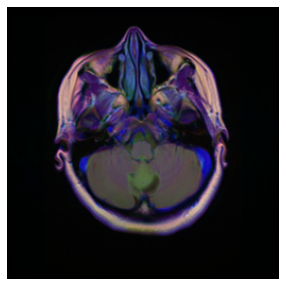

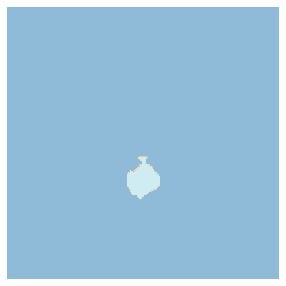

In [79]:
small_data_path = path/'TCGA_HT_7680_19970202'
pat=small_data_path/'TCGA_HT_7680_19970202_5.tif'
im=PILImage.create(pat)

im_mask=PILMask.create(get_y_fn(pat))


im.show()
im_mask.show()


im_size=im.shape[1]
m_size=im_mask.shape[1]
print("IMAGE SIZE: ",im_size)
print("MASK SIZE: ",m_size)


In [7]:
data=[]
mask=get_image_files(path)
for m in mask:
    if m.name.endswith('mask.tif'):
            if tensor(PILMask.create(m)).max()==255:
                data.extend([m.parts[4], 1])
            else:
                data.extend([m.parts[4],0])
            
            
           
        

In [8]:
df = pd.DataFrame({"dirname" : data[::2],
                  "diagnose" : data[1::2]})
df.head()

,dirname,diagnose
0,TCGA_CS_6669_20020102,1
1,TCGA_CS_6669_20020102,0
2,TCGA_CS_6669_20020102,1
3,TCGA_CS_6669_20020102,1
4,TCGA_CS_6669_20020102,0


In [9]:
negative,positive=df.diagnose.value_counts()
print("POSITIVE: ",positive)
print("NEGATIVE: ",negative)



POSITIVE:  1373
NEGATIVE:  2556


Text(0.5, 1.05, 'Distribution of data grouped by diagnosis')

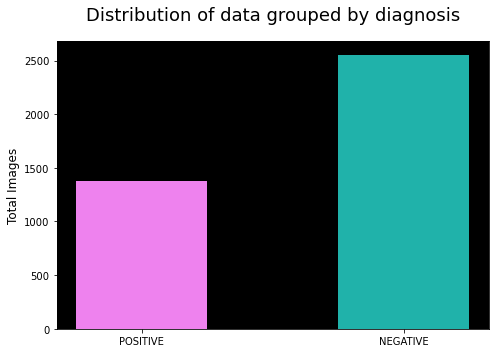

In [10]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
DIAGNOSIS = ['POSITIVE', 'NEGATIVE']
NO = [positive,negative]
ax.bar(DIAGNOSIS,NO,width=.5,color=["violet", "lightseagreen"])
ax.set_facecolor('xkcd:black')

ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

         

In [11]:
patients_by_diagnosis = df.groupby(['dirname', 'diagnose'])['diagnose'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Negative", "Positive"]

patients_by_diagnosis.head()

,Negative,Positive
dirname,,
TCGA_CS_4941_19960909,15,8
TCGA_CS_4942_19970222,14,6
TCGA_CS_4943_20000902,12,8
TCGA_CS_4944_20010208,11,9
TCGA_CS_5393_19990606,12,8


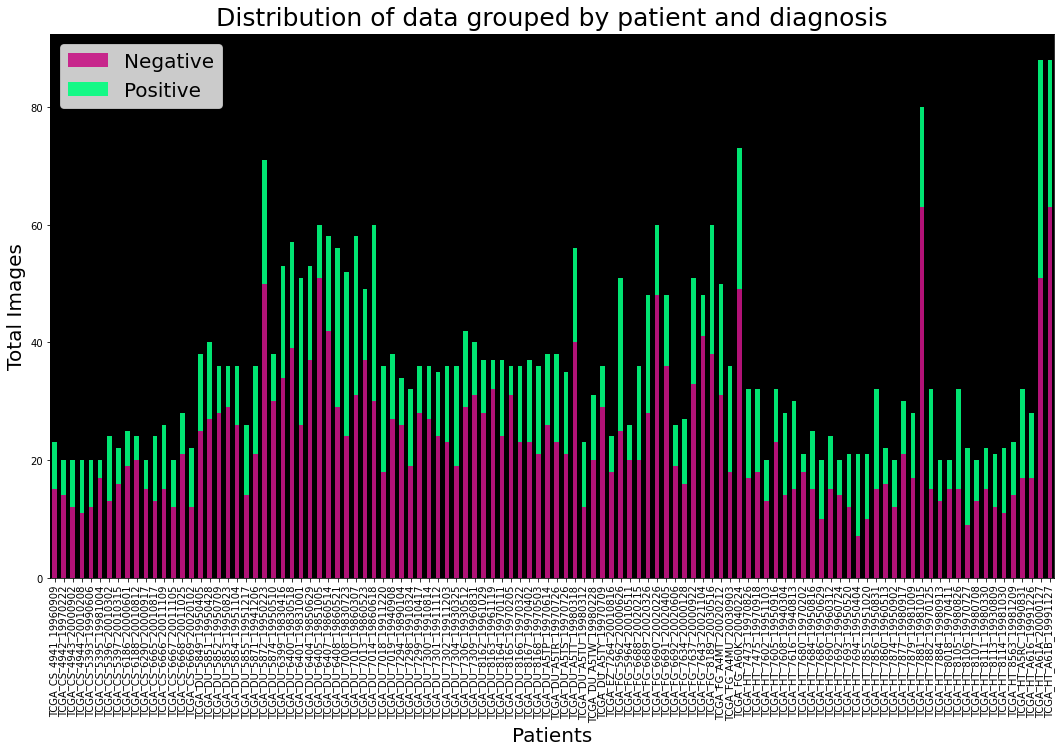

In [12]:
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)
ax.set_facecolor('xkcd:black')

# **Data Loader with Augmentaions**

In [13]:
validation_folders = [
        'TCGA_HT_7694_19950404', 'TCGA_DU_5874_19950510', 'TCGA_DU_7013_19860523',
        'TCGA_HT_8113_19930809', 'TCGA_DU_6399_19830416', 'TCGA_HT_7684_19950816',
        'TCGA_CS_5395_19981004', 'TCGA_FG_6688_20020215', 'TCGA_DU_8165_19970205',
        'TCGA_DU_7019_19940908', 'TCGA_HT_7855_19951020', 'TCGA_DU_A5TT_19980318',
        'TCGA_DU_7300_19910814', 'TCGA_DU_5871_19941206', 'TCGA_DU_5855_19951217']


In [14]:
def get_tuple_files(path):
    files = get_image_files(path)
    files = files.filter(lambda f: f.name.endswith('mask.tif'),negate=True)
    return files

In [15]:
def label_func(x):
      return x.parents[0] / (x.stem + '_mask' + x.suffix);
    

In [16]:

seg = DataBlock(blocks=(ImageBlock(), MaskBlock( codes =['n','y'])),
                
    item_tfms=[ToTensor],
    batch_tfms=[IntToFloatTensor(div_mask=255.0),*aug_transforms()],
    
    get_items=get_tuple_files,            
    splitter=FuncSplitter(lambda x: x.parts[-2] in validation_folders),
    get_y=label_func)
    

In [17]:
seg.summary(path)

Setting-up type transforms pipelines
Found 3929 items
2 datasets of sizes 3417,512
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_9.tif
    applying PILBase.create gives
      PILImage mode=RGB size=256x256
  Pipeline: label_func -> PILBase.create
    starting from
      ../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_9.tif
    applying label_func gives
      ../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_9_mask.tif
    applying PILBase.create gives
      PILMask mode=L size=256x256

Final sample: (PILImage mode=RGB size=256x256, PILMask mode=L size=256x256)


Setting up after_item: Pipeline: AddMaskCodes -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'd

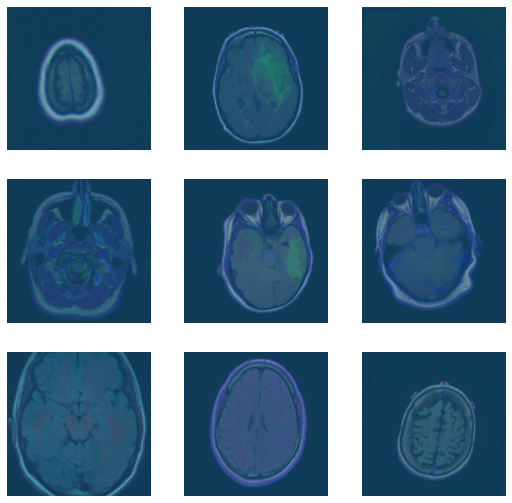

In [18]:
dls = seg.dataloaders(path,bs=16)
dls.show_batch()

DICE

Intuitive interpretation  |  Formula depending on the type of coefficient
:------------------------:|:-------------------------:
![](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png) | ![](https://d3i71xaburhd42.cloudfront.net/8575e8beef47bd2880c92f54a749f933db983e56/2-Table1-1.png)



In [19]:
from fastai import metrics

# **UNET with ResNet-34**
<p> 
    <img src="https://miro.medium.com/max/1400/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="650" height="300">
</p>

In [36]:
learn = unet_learner(dls,resnet34, metrics=[Dice()])

learn.summary()

DynamicUnet (Input shape: ['16 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 64 x 128 x 128  9,408      False     
________________________________________________________________
BatchNorm2d          16 x 64 x 128 x 128  128        True      
________________________________________________________________
ReLU                 16 x 64 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            16 x 64 x 64 x 64    0          False     
________________________________________________________________
Conv2d               16 x 64 x 64 x 64    36,864     False     
________________________________________________________________
BatchNorm2d          16 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 16 x 64 x 64 x 64    0          False     
________________________________________________

# **Training**

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=1.2022644114040304e-05)

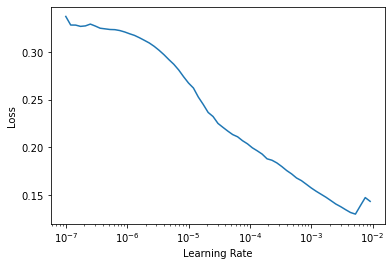

In [37]:
learn.lr_find()

In [38]:
learn.fine_tune(6,base_lr=5e-4)

epoch,train_loss,valid_loss,dice,time
0,0.022839,0.016183,0.722004,02:24


epoch,train_loss,valid_loss,dice,time
0,0.011017,0.012445,0.791930,02:31
1,0.009142,0.009753,0.824799,02:31
2,0.008032,0.010278,0.825526,02:31
3,0.006344,0.009514,0.844511,02:31
4,0.005481,0.009170,0.847347,02:31
5,0.005204,0.010130,0.841716,02:31


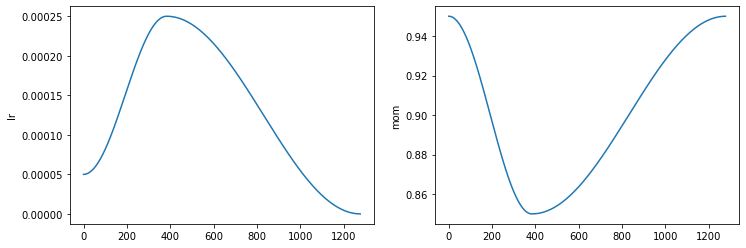

In [39]:
learn.recorder.plot_sched()

In [40]:
def save_and_show(name):
    saved_to = learn.save(name)
    print('Saved to :', saved_to)
    learn.load(name) 
    learn.show_results()

In [41]:
learn.export("model-34")

Saved to : models/stage-3(rn50).pth


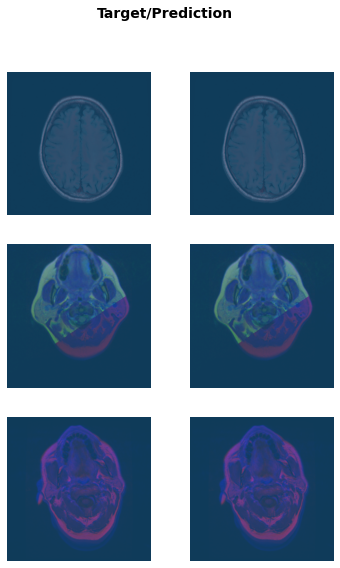

In [42]:
save_and_show('stage-3(rn50)')

> # **PREDICTION**

In [43]:
small_data_path = path/'TCGA_HT_7694_19950404'
path_pred=get_tuple_files(small_data_path)

In [77]:
im1=PILImage.create(path_pred[1])
mask1=PILMask.create(label_func(path_pred[1]))
pred1=learn.predict(im1)[0]

im2=PILImage.create(path_pred[10])
mask2=PILMask.create(label_func(path_pred[10]))
pred2=learn.predict(im2)[0]

im3=PILImage.create(path_pred[11])
mask3=PILMask.create(label_func(path_pred[11]))
pred3=learn.predict(im3)[0]



Text(0.5, 1.0, 'Prediction ')

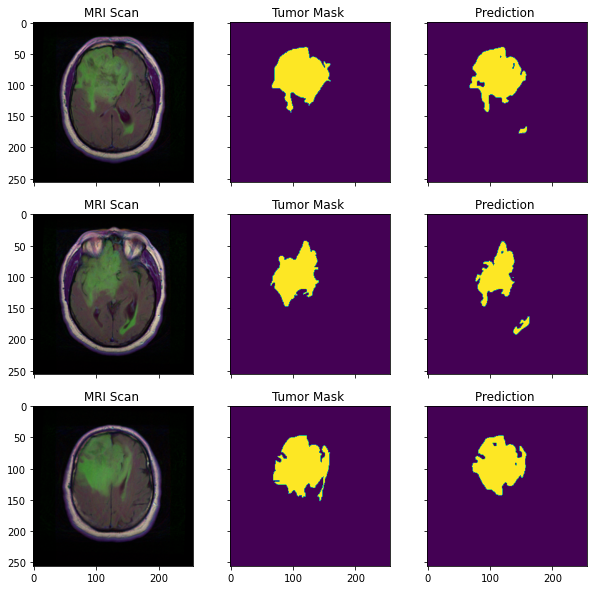

In [78]:
fig, axarr = plt.subplots(3,3, figsize=(10,10), sharex=True, sharey=True)


axarr[0][0].imshow(im1)
axarr[0][0].set_title(f'MRI Scan ')

axarr[0][1].imshow(mask1)
axarr[0][1].set_title(f'Tumor Mask ')

axarr[0][2].imshow(pred1)
axarr[0][2].set_title(f'Prediction ')

axarr[1][0].imshow(im2)
axarr[1][0].set_title(f'MRI Scan ')

axarr[1][1].imshow(mask2)
axarr[1][1].set_title(f'Tumor Mask ')

axarr[1][2].imshow(pred2)
axarr[1][2].set_title(f'Prediction ')

axarr[2][0].imshow(im3)
axarr[2][0].set_title(f'MRI Scan ')

axarr[2][1].imshow(mask3)
axarr[2][1].set_title(f'Tumor Mask ')

axarr[2][2].imshow(pred3)
axarr[2][2].set_title(f'Prediction ')
